In [1]:
from utils import *

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Perform Sanity Checks

### Check for missing values in the datasets

Check if the train dataset contains any missing values in its columns.

In [2]:
check_missing_columns(train)

id                False
industry           True
state             False
request_date      False
term              False
employee_count    False
business_new      False
business_type     False
location          False
other_loans       False
loan_amount       False
insured_amount    False
default_status    False
dtype: bool

Industry column in train dataset contains missing values. Let's dive deeper to see how many records contains missing industry.

In [3]:
train[train.industry.isna()]

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
1946,3771775001,NaN,NH,20-Nov-09,12,1,New,0,Rural,N,$100.00,"$75,000.00",0


1 record contains missing industry value. Let's drop that record.

In [4]:
train = train.dropna()
train.shape

(2401, 13)


Check if the test dataset contains any missing values in its columns.

In [5]:
check_missing_columns(test)

id                False
industry          False
state             False
request_date      False
term              False
employee_count    False
business_new      False
business_type     False
location          False
other_loans       False
loan_amount       False
insured_amount    False
dtype: bool

Test dataset does not contain any missing values.

### Check if the test dataset contains categorical values that are not present in train dataset.

In [6]:
columns_missing_categories = check_categories(
    test, train, 
    categorical_fields = ['industry', 'state', 'business_new', 'business_type', 'location', 'other_loans']
)
columns_missing_categories

Checking categorical column: industry
Unique categories in train: {'Energy', 'Construction', 'Healthcare', 'Hotel', 'Trading', 'Engineering', 'Transportation', 'Entertainment', 'Consulting', 'Others', 'Education', 'Administration', 'Finance', 'Manufacturing', 'Real Estate', 'Agriculture'}
Unique categories in test: {'Energy', 'Construction', 'Healthcare', 'Hotel', 'Trading', 'Entertainment', 'Transportation', 'Engineering', 'Consulting', 'Others', 'Education', 'Administration', 'Finance', 'Manufacturing', 'Real Estate', 'Agriculture'}
Categories in test but not train: set()

Checking categorical column: state
Unique categories in train: {'IN', 'PA', 'ND', 'HI', 'NJ', 'NV', 'ME', 'NY', 'MS', 'AK', 'VT', 'WI', 'AR', 'IL', 'IA', 'MT', 'RI', 'AZ', 'DE', 'OK', 'AL', 'WY', 'UT', 'NH', 'LA', 'WA', 'CT', 'SC', 'WV', 'OH', 'NE', 'TX', 'CO', 'NC', 'KS', 'FL', 'ID', 'MN', 'TN', 'MO', 'CA', 'MI', 'KY', 'MA', 'OR', 'MD', 'NM', 'VA', 'GA', 'SD'}
Unique categories in test: {'IN', 'PA', 'ND', 'HI', 'N

[]

All of the categorical values present in test dataset can also be found in the train dataset. Additionally, it could be observed that the location field only has one unique value, 'Rural' in both the train and test datasets. Since every record has the same location 'Rural', the location field would not have any discriminative power over default_status. Hence, let's drop the location field from the potential list of features to include in the model.

In [7]:
train = train.drop(columns = ['location'])
test = test.drop(columns = ['location'])

## Perform Data Preprocessing

### Preprocessing Steps:

1) Cast request_date to a datetime object.
2) Cast loan_amount and insured_amount to float.

In [8]:
train = convert_to_datetime(train)
train = convert_amt_cols_to_float(train, amt_cols = ['loan_amount', 'insured_amount'])
train.head(2)

loan_amount
<class 'str'>    2401
Name: count, dtype: int64
count    2.401000e+03
mean     2.045728e+05
std      3.643876e+05
min      3.000000e+03
25%      2.500000e+04
50%      5.000000e+04
75%      2.169900e+05
max      4.000000e+06
Name: loan_amount, dtype: float64

insured_amount
<class 'str'>    2401
Name: count, dtype: int64
count    2.401000e+03
mean     1.550500e+05
std      3.114833e+05
min      1.700000e+03
25%      1.275000e+04
50%      3.500000e+04
75%      1.250000e+05
max      4.000000e+06
Name: insured_amount, dtype: float64



,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,2010-04-27,34,4,New,0,N,35000.0,35000.0,1
1,3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,N,15000.0,13500.0,1


In [9]:
test = convert_to_datetime(test)
test = convert_amt_cols_to_float(test, amt_cols = ['loan_amount', 'insured_amount'])
test.head(2)

loan_amount
<class 'str'>    601
Name: count, dtype: int64
count    6.010000e+02
mean     1.885422e+05
std      3.085025e+05
min      2.000000e+03
25%      2.500000e+04
50%      5.194000e+04
75%      2.180000e+05
max      2.000000e+06
Name: loan_amount, dtype: float64

insured_amount
<class 'str'>    601
Name: count, dtype: int64
count    6.010000e+02
mean     1.469891e+05
std      2.720625e+05
min      1.000000e+03
25%      1.275000e+04
50%      3.500000e+04
75%      1.275000e+05
max      1.500000e+06
Name: insured_amount, dtype: float64



,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount
0,3999155010,Hotel,CA,2010-03-26,91,1,Existing,1,N,270000.0,243000.0
1,4035035009,Hotel,WA,2010-04-19,124,0,Existing,0,N,443574.0,432000.0


## Perform Feature Engineering 

### Features to create

1. loan_insured_amount_diff: Difference between loan_amount and insured_amount (i.e. loan_amount - insured_amount)
2. insured_loan_ratio: Ratio between insured_amount and loan_amount (i.e. insured_amount / loan_amount)

In [10]:
train = create_loan_insured_features(train)
train.head(2)

,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,default_status,loan_insured_amount_diff,insured_loan_ratio
0,4050975007,Others,VA,2010-04-27,34,4,New,0,N,35000.0,35000.0,1,0.0,1.0
1,3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,N,15000.0,13500.0,1,1500.0,0.9


In [11]:
test = create_loan_insured_features(test)
test.head(2)

,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,loan_insured_amount_diff,insured_loan_ratio
0,3999155010,Hotel,CA,2010-03-26,91,1,Existing,1,N,270000.0,243000.0,27000.0,0.900000
1,4035035009,Hotel,WA,2010-04-19,124,0,Existing,0,N,443574.0,432000.0,11574.0,0.973907


## Perform Exploratory Data Analysis

### Analyse the request date distributions in train and test datasets.

In [12]:
train.request_date.describe()

count                             2401
mean     2010-03-15 00:34:47.130362368
min                2009-10-01 00:00:00
25%                2009-12-14 00:00:00
50%                2010-03-11 00:00:00
75%                2010-06-02 00:00:00
max                2010-09-30 00:00:00
Name: request_date, dtype: object

In [13]:
test.request_date.describe()

count                              601
mean     2010-03-11 00:38:20.166389248
min                2009-10-01 00:00:00
25%                2009-12-09 00:00:00
50%                2010-03-04 00:00:00
75%                2010-06-07 00:00:00
max                2010-09-30 00:00:00
Name: request_date, dtype: object

The request_date range for both the train and test datasets are the same, starting from 2009-10-01 and ending on 2010-09-30. request_date wise, it seems that both the train and test datasets were drawn from the same distribution.

### Analyse the distribution of target variable, default_status

In [14]:
plot_categories_distribution(train, 'default_status', width = 800, height = 400)

It could be observed that the train dataset is imbalanced in terms of the target variable, default status. The number of companies that do not default (i.e. default_status = 0) is ~2x of the number of companies that default (i.e. default_status = 1). In such a case, accuracy might not be the most appropriate performance metric to use, as it is bias towards the majority class (i.e. default_status = 0). Instead f1 might be a more appropriate performance metric to use, as it is the harmonic mean of precision and recall, and hence unbiased towards either of the classes.

### Analyse the probability of default given a categorical value

In [15]:
plot_category_default_distribution(train, 'industry')

The plot above suggests that there is a strong correlation between the industry and the default status. Some industries are significantly more prone to default as compared to others.

For example, it could be observed that the top 3 industries most likely to default are Construction, Hotel and Engineering, each having more than or equal to 0.375 probability of default. On the other hand, the Energy industry is the least likely to default, with only a 0.11 probability of default.

In [16]:
plot_category_default_distribution(train, 'state')

The plot above suggests that there is a strong correlation between the state and the default status. Some states are significantly more prone to default as compared to others.

For example, it could be observed that companies in the states DE, AZ, GA and AR are likely to default more than 50% of the time (i.e. their probability of default is greater than 0.5), whereas companies in the state CT are likely to default only 11% of the time (i.e. their probability of default = 0.11)

In [17]:
plot_category_default_distribution(train, 'business_new', height = 400)

The plot above suggests that there is no strong correlation between business_new and the default status, given that the probability of default for New and Existing businesses is approximately the same at 0.3; New and Existing businesses are equally likely to default.

In [18]:
plot_category_default_distribution(train, 'business_type', height = 400)

The plot above suggests a weak correlation between business_type and the default status, given that the probability of default for business_type = 0 (i.e. 0.33) is slightly higher than business_type = 1 (i.e. 0.27).

In [19]:
plot_category_default_distribution(train, 'other_loans', height = 400)

The plot above suggests a moderate correlation between other_loans and the default status, given that the probability of default for no other loans = 0 (i.e. 0.36) is moderately higher than with other loans (i.e. 0.22).

### Analyse the correlation between numerical feature values and default status

In [20]:
px.box(train, x = 'term', color = 'default_status')

From the plot above, it could be observed that in general, companies tend to default on loans with shorter terms. The median loan term for default is 57 whereas the median loan term for non-default is 84.

In [21]:
px.box(train, x = 'employee_count', color = 'default_status')

From the plot above, it could be observed that in general, the companies that default have fewer employees (i.e. median 3) than companies that do not default (i.e. median 4).

In [22]:
px.box(train, x = 'loan_amount', color = 'default_status')

From the plot above, it could be observed that companies tend to default on smaller loan amounts. The median default loan amount is 33k, whereas the median non-default loan amount is 95.911k.

In [23]:
px.box(train, x = 'insured_amount', color = 'default_status')

From the plot above, it could be observed that companies tend to default when the insured amount is lesser. The median default insured amount is 22.5k, whereas the median non-default insured amount is 50k.

In [24]:
px.box(train, x = 'loan_insured_amount_diff', color = 'default_status')

From the plot above, it could be observed that companies tend to default when the difference between the loan amount and insured amount, loan_insured_amount_diff is lesser. The median default loan_insured_amount_diff is 2250, whereas the median non-default loan_insured_amount_diff is 24.75k.

In [25]:
px.box(train, x = 'insured_loan_ratio', color = 'default_status')

From the plot above, it could be observed that companies tend to default when the insured_loan_ratio is higher. The median default insured_loan_ratio is 0.9, whereas the median non-default insured_loan_ratio is 0.75.

## Encode categorical features into numerical values

In [26]:
train, test, encoder_dict = encode_categorical_features(train, test)

## Perform Nested Stratified K-Fold Cross-Validation

We perform nested stratified k-fold cross-validation to estimate:
- The average model performance on the full train dataset
- The final number of boosting rounds required for training with the full train dataset

### How this works

1) We first stratify split our train dataset into N partitions, based on the default_status label.
2) We keep 1 partition as the held-out test set and use the remaining N - 1 partitions for model training and validation.
3) We then further stratify split the N - 1 parititions dataset into another K partitions, based on the default_status label and perform K-fold cross validation with it. How this works is that we use K - 1 partitions for training and the remaining 1 partition for hyperparameter tuning. We repeat this process iteratively until all K partitions have been used for hyperparameter tuning. From these series of experiments, we estimate the optimal set of hyperparameters to use for training on the full N - 1 partitions dataset.
4) Following which, we train our model with the full N - 1 partitions dataset and the optimal set of hyperparameters.
5) After that, we compute the performance of our model (i.e. trained on N - 1 partitions dataset) on the held-out test set.
6) We repeat steps 2 - 5 iteratively until all N partitions have been used as the held-out test set.
7) Finally, we compute the average test performance of the models based on all N held-out test sets.

In [27]:
num_folds = 5

# Factor to scale num_boost_rounds by in lightgbm model training
# Factor is calculated based on the ratio of full dataset size / dataset size used for training during each fold of cross validation
scaling_factor = num_folds / (num_folds - 1)

features = ['industry', 'state', 'term', 'employee_count',
       'business_new', 'business_type', 'other_loans', 'loan_amount',
       'insured_amount', 'loan_insured_amount_diff', 'insured_loan_ratio']
cat_features = ['industry', 'state', 'business_new', 'business_type', 'other_loans']

# Perform nested stratified k fold cross validation
stratified_kfold_results = nested_stratified_kfold_cv(train, features, cat_features, num_folds = 5, scaling_factor = scaling_factor)

Outer train shape: (1920, 14)
test shape: (481, 14)
Inner train shape: (1536, 14)
val shape: (384, 14)
[LightGBM] [Info] Number of positive: 494, number of negative: 1042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321615 -> initscore=-0.746362
[LightGBM] [Info] Start training from score -0.746362
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.281848
Best iteration: 60
Validation accuracy: 0.8958333333333334
Inner train shape: (1536, 14)
val shape: (384, 14)
[LightGBM] [Info] Number of positive: 494, number of negative: 1042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

### Compute average model performance metrics on validation and test sets

In [28]:
avg_val_acc = np.mean(stratified_kfold_results['val_acc'])
avg_test_acc = np.mean(stratified_kfold_results['test_acc'])
avg_num_boost_rounds = int(np.mean(stratified_kfold_results['test_num_boost_rounds']))

print(f'Average validation model accuracy: {avg_val_acc}')
print(f'Average test model accuracy: {avg_test_acc}')
print(f'Average test num_boost_rounds: {avg_num_boost_rounds}')

Average validation model accuracy: 0.889939935064935
Average test model accuracy: 0.9054487179487181
Average test num_boost_rounds: 60


## Train model on full train dataset

In [29]:
model_path = './models/model_final.txt'
full_num_boost_rounds = int(np.mean(stratified_kfold_results['test_num_boost_rounds']) * scaling_factor)
print(f' Number of iterations used to train model on full dataset: {full_num_boost_rounds}')
final_model = train_lgb_model(
    train = train, 
    num_boost_rounds = full_num_boost_rounds, 
    features = features, 
    cat_features = cat_features,
    model_path = model_path,
)

 Number of iterations used to train model on full dataset: 75
[LightGBM] [Info] Number of positive: 773, number of negative: 1628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 2401, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321949 -> initscore=-0.744828
[LightGBM] [Info] Start training from score -0.744828


Run model inference on test dataset and save the inference results to a csv file.

In [30]:
generate_submissions(final_model, test, features = features)

test shape: (601, 13)
Submissions shape: (601, 2)
Saved submissions to submissions_addison.csv.


### Explain how different features impact model predictions with SHAP values

In [31]:
import shap

explainer = shap.Explainer(final_model.predict, test[features])
shap_values = explainer(test[features])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Permutation explainer: 602it [01:06,  8.00it/s]                         


### Overall Feature Importance

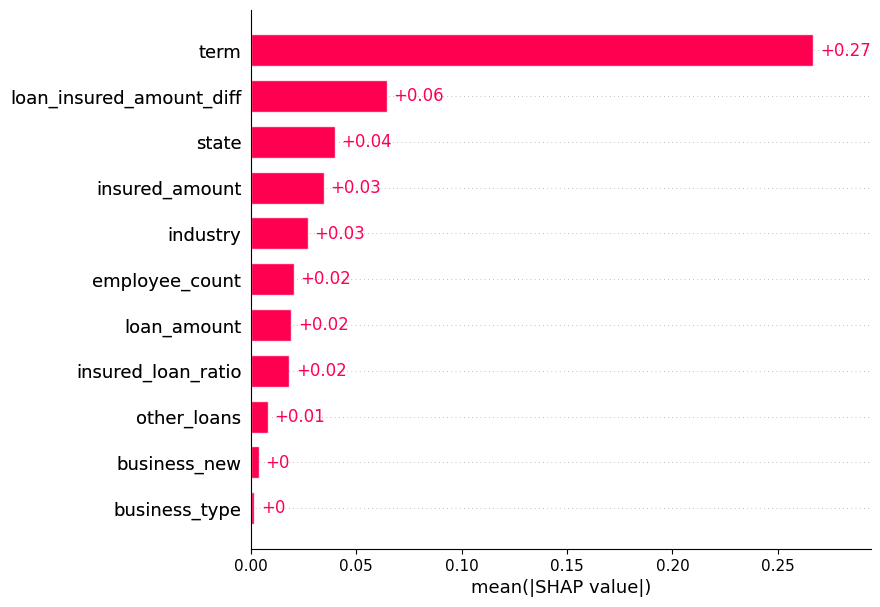

In [32]:
max_display = 11
shap.plots.bar(shap_values, max_display = max_display)

From the plot above, it could be observed that the top 5 most influential features, in descending order are:
1. term
2. loan_insured_amount_diff
3. state
4. insured_amount
5. industry

The bottom 2 features, business_new and business_type, are observed to have minimal to no effect on the model predictions.

### Effect of feature values on model predictions

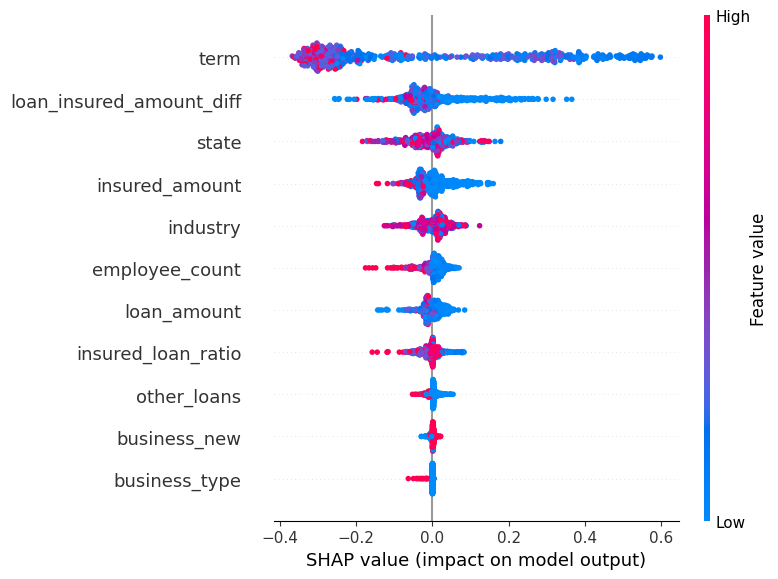

In [36]:
shap.summary_plot(shap_values)

From the plot above, it could be observed that in general, lower values of term, loan_insured_amount_diff, insured_amount, employee_count and insured_loan_ratio have a positive impact on the model prediction score (i.e. increased probability of default), while higher values have a negative impact on the model prediction score (i.e. decreased probability of default).

### Local contribution of feature values on model prediction for a single observation

Local contribution of features values on model prediction, default_status = 1 for a single observation

id                                   3794845001
industry                                     15
state                                        20
request_date                2009-12-04 00:00:00
term                                         29
employee_count                                8
business_new                                  1
business_type                                 0
other_loans                                   1
loan_amount                            340000.0
insured_amount                          75000.0
loan_insured_amount_diff               265000.0
insured_loan_ratio                     0.220588
default_status                                1
Name: 3, dtype: object


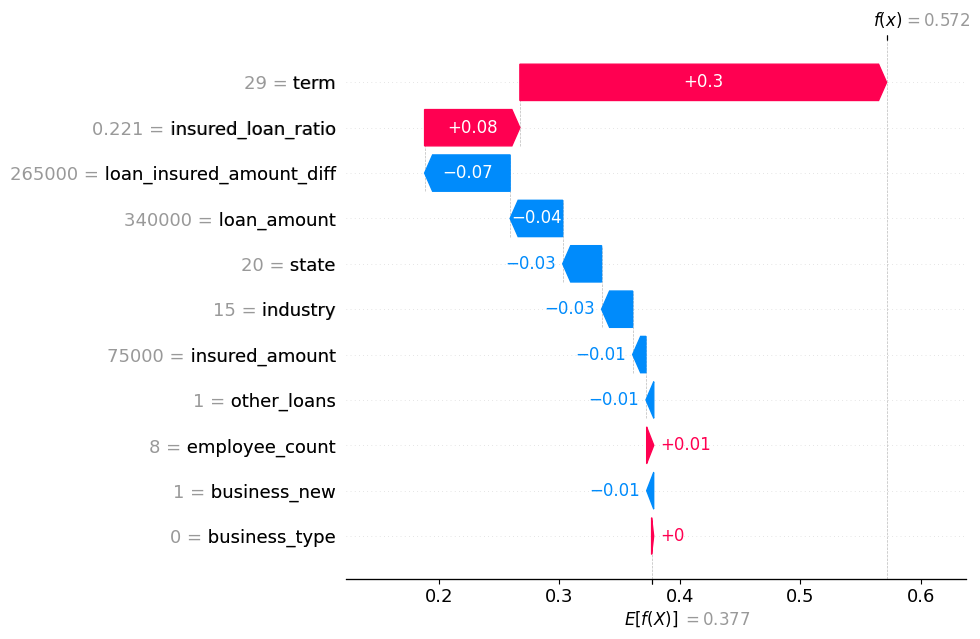

In [48]:
idx = test[test.default_status == 1].index[0]
print(test.iloc[idx])
shap.plots.waterfall(shap_values[idx], max_display = max_display)

From the plot above, it could be observed that a short term (i.e. 29) and low insured_loan_ratio (i.e. 0.221) heavily influences the model to predict that the company is highly likely to default. Conversely, a high loan_insured_amount_diff (i.e. 265,000), influences the model to predict that the company is less likely to default.

Local contribution of features values on model prediction, default_status = 0 for a single observation

id                                   3901935000
industry                                     12
state                                        21
request_date                2010-02-11 00:00:00
term                                         84
employee_count                                1
business_new                                  0
business_type                                 0
other_loans                                   1
loan_amount                             66073.0
insured_amount                          15000.0
loan_insured_amount_diff                51073.0
insured_loan_ratio                     0.227022
default_status                                0
Name: 600, dtype: object


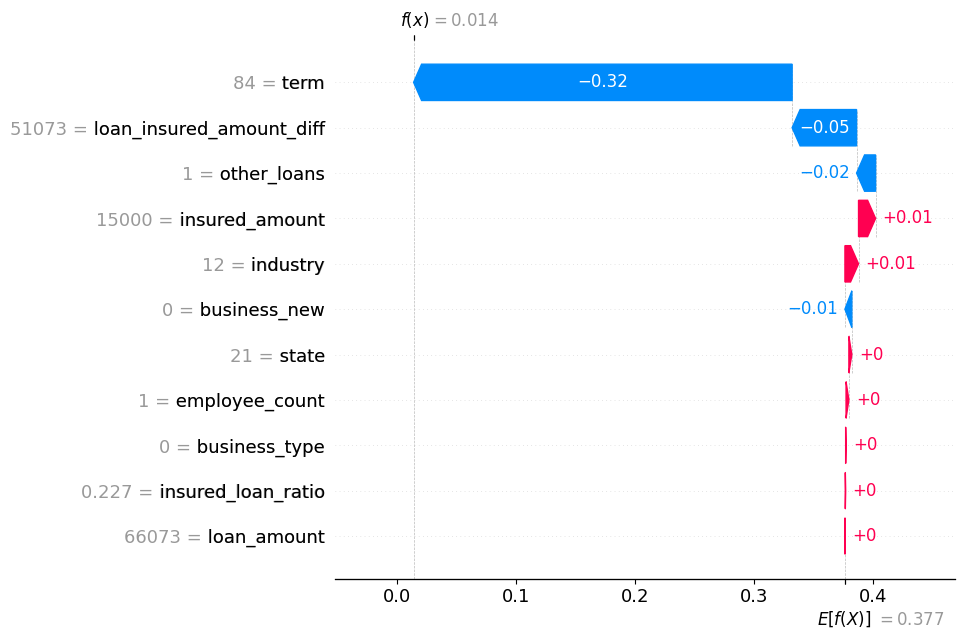

In [50]:
idx = test[test.default_status == 0].index[-1]
print(test.iloc[idx])
shap.plots.waterfall(shap_values[idx], max_display = max_display)

From the plot above, it could be observed that a long term (i.e. 84) and high loan_insured_amount_diff (i.e. 51,073) heavily influences the model to predict that the company is very unlikely to default.